# Natural Language Geneartion
Generate new Answer Cards using RNN

#### Pre-processing  
Length of vocab: 1465  
Length of first line: 5

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import silhouette_score
from sklearn import metrics

import numpy as np
import random
import pandas as pd
import os
import pickle

In [28]:
os.chdir('/Users/bellepeng/Desktop/Metis/Projects/NLP_CardsAgainstHumanity')

In [4]:
with open('w2v_pred_words_flat.pkl', 'rb') as picklefile:
    w2v_pred_words_flat = pickle.load(picklefile)
    
print("Length of vocab:", len(w2v_pred_words_flat)) # Length of vocab
print("Length of first line:", len(w2v_pred_words_flat[1]))

Length of vocab: 1465
Length of first line: 5


In [45]:
# file = unidecode.unidecode(open('CAH_predicted_answers.txt').read())
with open('CAH_predicted_answers.txt', 'r') as text:
    file = text.read()#.split('\n')

file = file.replace('\n', ' ')
file = file.replace("\'", "'")
file = file.replace("<br>", " ")
file

'Why can\'t I sleep at night? Salsa Night at Dave\'s Cantina.   Why can\'t I sleep at night? Turning 32.   Why can\'t I sleep at night? Wearing glasses and sounding smart.   Why can\'t I sleep at night? Shitting all over the floor like a bad, bad girl.   Why can\'t I sleep at night? The passage of time.   I got 99 problems but _ ain\'t one. Intimacy problems.   I got 99 problems but _ ain\'t one. A web of lies.   I got 99 problems but _ ain\'t one. The Google.   I got 99 problems but _ ain\'t one. A sea of troubles.   I got 99 problems but _ ain\'t one. A rival dojo.   What\'s a girl\'s best friend? Bees?   What\'s a girl\'s best friend? Happy daddies with happy sandals.   What\'s a girl\'s best friend? Opening your mouth to talk and a big penis fops out.   What\'s a girl\'s best friend? Seeing things from Hitler\'s perspective   What\'s a girl\'s best friend? A medium horchata.   What\'s that smell? Bees?   What\'s that smell? Putting an entire peanut butter and jelly sandwich into th

### Model

In [46]:
# Read in text and change unicode characters to ASCII
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file_len = len(file)
print(f'file_len = {file_len}')

file_len = 128877


In [50]:
chunk_len = 100

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

ners must endure _ for all eternity. White people.   In the seventh circle of Hell, sinners must endu


In [51]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size #chunks
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        output = self.encoder(input.view(1, -1))
        output, hidden = self.gru(output.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.randn(self.n_layers, 1, self.hidden_size))

In [52]:
def char2tensor(string):
    tensor = torch.zeros(len(string)).long()
    for char in range(len(string)):
        if string[char] in all_characters:
            tensor[char] = all_characters.index(string[char])
        else:
            tensor[char] = 94 #predict space if character unknown
        
    return Variable(tensor)

# Let's see it in action.
# print(char2tensor('Metis'))
# print(string.printable)
# print(char2tensor(all_characters))

In [53]:
def random_training_set():
    chunk = random_chunk()
    inp = char2tensor(chunk[:-1])
    target = char2tensor(chunk[1:])
    return inp, target

In [54]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    
    hidden = model.init_hidden()
    prime_input = char2tensor(prime_str)
    predicted = prime_str
    
    # use priming string to build up hidden state
    
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char2tensor(predicted_char)
        
    return predicted

#### Training

In [55]:
# helper function
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

In [56]:
# The actual training part
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for char in range(chunk_len):
        output, hidden = model(inp[char], hidden)
        loss += criterion(output, target[char].unsqueeze(0))

    loss.backward()
    model_optimizer.step()

    return loss.data.item() / chunk_len

In [101]:
# parameters
n_epochs = 5000
print_every = 100
plot_every = 20
hidden_size = 256
n_layers = 2
learning_rate = 0.001

# model declaration
model = RNN(n_characters, hidden_size, n_characters, n_layers)
model_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, 'A ', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 37s (100 2%) 2.7065]
A Hheacithe fther the fun il The in mho _. sMbis. Reragor kitan _. sedn.  Riste val sher ffou ar medis 

 16s (200 4%) 2.0171]
A ul deres fres. The an woubing for what leverawet weor; freret fund of wisis _! got halp _. Han nile  

 56s (300 6%) 2.0886]
A histis all your _. The my soarcing ackoon yout us in to the the sar wavie by come with Getrilding ha 

 35s (400 8%) 2.0740]
A Hithems you dull up and for palibly lome anfill in to _ and cercukest with, enile the.   Loun offiil 

 11s (500 10%) 2.2057]
A winting hivuing.   I'ms the to am _. I will sept fir _. Ard Peaduse ope.   In to like frials the fur 

 44s (600 12%) 2.3161]
A Wa se, Hor? Onous _. Getting the Pamvers the sex puson verty. Ood.   What sear soce in _. Hill buck  

 22s (700 14%) 1.8028]
A bofeve _. Piver thing Jain't part intime fusing _ what Mistuy.   If thee with shot the what of Whot' 

 5s (800 16%) 1.8569]
A millife the beliend sets rechially endid _. Goldincens.   The wowled us dows one, pr

Text(0,0.5,'Neg Log Likelihood Loss')

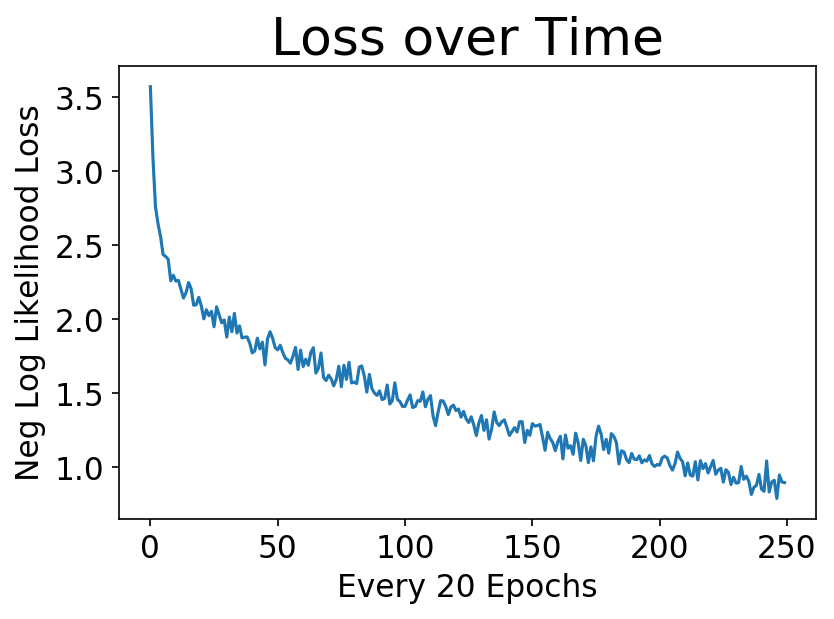

In [105]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure(dpi=150)
plt.plot(all_losses)
plt.title('Loss over Time', size=25)
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Every 20 Epochs', fontsize=15)
plt.ylabel('Neg Log Likelihood Loss', fontsize=15)

In [113]:
# Evaluate Trump
print(evaluate(model, "What is Batman's guilty pleasure?", predict_len=100, temperature=0.5))

What is Batman's guilty pleasure? Daddy's boner down on the nudist corned until you'd get rid of _. A black enough for _. Becoming or


In [104]:
import pickle
os.chdir('/Users/bellepeng/Desktop/Metis/Projects/NLP_CardsAgainstHumanity')
with open('model_nlg_2.pkl', 'wb') as picklefile:
    pickle.dump(model, picklefile)